In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### RFID data

#### Get paths for files to process

In [2]:
#create list of dir paths
RFID_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r1.3m'
    
RFID_file_names = os.listdir(RFID_path)

RFID_data_dir_paths = []

for file in RFID_file_names:
    int_path = RFID_path + '/' + file
    RFID_data_dir_paths.append(int_path)
    
RFID_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r1.3m/Idspyder-20.11.20.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r1.3m/Idspyder-20.11.24.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r1.3m/Idspyder-20.11.27.csv']

#### Clean df and combine into 1

In [3]:
data_RFID = pd.DataFrame()

for path in RFID_data_dir_paths:
    print(path)
    
    #create data table
    data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')
    data_RFID_int = pd.DataFrame(data = data_RFID_int)
    data_RFID_int = data_RFID_int.drop([0,1,2,3,4,5,6,7,8])

    print(data_RFID_int.shape)
    
    #drop rows with no event duration
    data_RFID_int = data_RFID_int[~data_RFID_int['eventDuration'].isna()]
    
    #convert from ms to sec
    data_RFID_int['eventDuration'] = data_RFID_int['eventDuration']/1000
    #clean up and create datetime columns
    data_RFID_int['start_datetime'] = pd.to_datetime(data_RFID_int['DateTime'], unit='d')
    #can't figure out datetime format so hard code for now
    data_RFID_int['RFID_datetime_start'] = [x.replace(year = 2020) - dt.timedelta(days = 2) for x in data_RFID_int['start_datetime']] 
    data_RFID_int['RFID_date'] = data_RFID_int['RFID_datetime_start'].dt.date 
    data_RFID_int['RFID_day'] = data_RFID_int['RFID_datetime_start'].dt.day 
    data_RFID_int['RFID_time_start'] = [x.split(' ')[1] for x in data_RFID_int['RFID_datetime_start'].dt.strftime("%Y-%m-%d %H:%M:%S")]
    data_RFID_int['RFID_hour'] = data_RFID_int['RFID_datetime_start'].dt.hour
    data_RFID_int['RFID_min'] = data_RFID_int['RFID_datetime_start'].dt.minute

    if data_RFID.empty:
        data_RFID = data_RFID_int
    else:
        data_RFID = pd.concat([data_RFID, data_RFID_int], axis=0)
        
    print(data_RFID.shape,'\n')

#clean columns
data_RFID = data_RFID[['IdRFID', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date',
       'RFID_day', 'RFID_time_start', 'RFID_hour', 'RFID_min']]
    
data_RFID.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r1.3m/Idspyder-20.11.20.csv
(19976, 14)
(19975, 21) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r1.3m/Idspyder-20.11.24.csv
(13585, 14)
(33559, 21) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r1.3m/Idspyder-20.11.27.csv
(60907, 14)
(94465, 21) 



,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min
9,041A555DFF,RFID3,4.447,2020-11-20 15:21:51.250982400,2020-11-20,20,15:21:51,15,21
10,041A55594C,RFID2,3.833,2020-11-20 15:21:53.062012800,2020-11-20,20,15:21:53,15,21
11,041A555768,RFID6,0.616,2020-11-20 15:21:59.075020800,2020-11-20,20,15:21:59,15,21
12,041A555A78,RFID2,13.198,2020-11-20 15:22:08.009990400,2020-11-20,20,15:22:08,15,22
13,041A555768,RFID5,5.315,2020-11-20 15:22:19.182979200,2020-11-20,20,15:22:19,15,22


#### Compute endtime 

In [4]:
#compute end time for each eventDuration
def add_duration(a, b):
    newtime = a + dt.timedelta(0, b)

    return newtime

data_RFID['RFID_datetime_end'] = data_RFID.apply(lambda row: add_duration(row['RFID_datetime_start'], row['eventDuration']), axis=1)
data_RFID['RFID_time_end'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_end'].dt.strftime("%Y-%m-%d %H:%M:%S")]

print(data_RFID.shape)
data_RFID.head()

(94465, 11)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end
9,041A555DFF,RFID3,4.447,2020-11-20 15:21:51.250982400,2020-11-20,20,15:21:51,15,21,2020-11-20 15:21:55.697982400,15:21:55
10,041A55594C,RFID2,3.833,2020-11-20 15:21:53.062012800,2020-11-20,20,15:21:53,15,21,2020-11-20 15:21:56.895012800,15:21:56
11,041A555768,RFID6,0.616,2020-11-20 15:21:59.075020800,2020-11-20,20,15:21:59,15,21,2020-11-20 15:21:59.691020800,15:21:59
12,041A555A78,RFID2,13.198,2020-11-20 15:22:08.009990400,2020-11-20,20,15:22:08,15,22,2020-11-20 15:22:21.207990400,15:22:21
13,041A555768,RFID5,5.315,2020-11-20 15:22:19.182979200,2020-11-20,20,15:22:19,15,22,2020-11-20 15:22:24.497979200,15:22:24


#### Add next column (do for each unitLabel separately)

In [5]:
#column for if next is same Id
def next_compare(a, b):
    if a == b:
        compare = 'same'
        
    if a != b:
        compare = 'diff'

    return compare

data_RFID_next = pd.DataFrame()

for unitlabel in data_RFID['unitLabel'].unique():
    print(unitlabel)

    data_int = data_RFID[data_RFID['unitLabel'] == unitlabel].sort_values(['RFID_datetime_start'])
    data_int['RFID_datetime_start_next'] = data_int['RFID_datetime_start'].shift(-1)
    data_int['IdRFID_next'] = data_int['IdRFID'].shift(-1)
    
    data_int['IdRFID_diff_next'] = data_int.apply(lambda row: next_compare(row['IdRFID'], row['IdRFID_next']), axis=1)

    if data_RFID_next.empty:
        data_RFID_next = data_int
    else:
        data_RFID_next = pd.concat([data_RFID_next, data_int], axis=0)

data_RFID_next['time_diff_next'] = (data_RFID_next['RFID_datetime_start_next'] - data_RFID_next['RFID_datetime_end'])
data_RFID_next['time_diff_next'] = [x.total_seconds() for x in data_RFID_next['time_diff_next']]

data_RFID_next.head()

RFID3
RFID2
RFID6
RFID5
RFID1
RFID7
RFID4
RFID8


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next
9,041A555DFF,RFID3,4.447,2020-11-20 15:21:51.250982400,2020-11-20,20,15:21:51,15,21,2020-11-20 15:21:55.697982400,15:21:55,2020-11-20 15:22:30.311040000,041A555A78,diff,34.613057
15,041A555A78,RFID3,0.812,2020-11-20 15:22:30.311040000,2020-11-20,20,15:22:30,15,22,2020-11-20 15:22:31.123040000,15:22:31,2020-11-20 15:26:59.914982400,041A555DFF,diff,268.791942
48,041A555DFF,RFID3,0.800,2020-11-20 15:26:59.914982400,2020-11-20,20,15:26:59,15,26,2020-11-20 15:27:00.714982400,15:27:00,2020-11-20 15:27:01.808006400,041A555DFF,same,1.093024
51,041A555DFF,RFID3,3.503,2020-11-20 15:27:01.808006400,2020-11-20,20,15:27:01,15,27,2020-11-20 15:27:05.311006400,15:27:05,2020-11-20 15:27:25.383024000,041A555A78,diff,20.072017
53,041A555A78,RFID3,1.602,2020-11-20 15:27:25.383024000,2020-11-20,20,15:27:25,15,27,2020-11-20 15:27:26.985024000,15:27:26,2020-11-20 15:30:13.995993600,041A555DFF,diff,167.010969


#### Add light dark

In [6]:
def assign_ld(time):
    if (time > 5) & (time < 18):
        return 'light'
    else:
        return 'dark'
    
data_RFID_next['ld_seg'] = data_RFID_next['RFID_hour'].apply(assign_ld)

print(data_RFID_next.shape)
data_RFID_next.head()

(94465, 16)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld_seg
9,041A555DFF,RFID3,4.447,2020-11-20 15:21:51.250982400,2020-11-20,20,15:21:51,15,21,2020-11-20 15:21:55.697982400,15:21:55,2020-11-20 15:22:30.311040000,041A555A78,diff,34.613057,light
15,041A555A78,RFID3,0.812,2020-11-20 15:22:30.311040000,2020-11-20,20,15:22:30,15,22,2020-11-20 15:22:31.123040000,15:22:31,2020-11-20 15:26:59.914982400,041A555DFF,diff,268.791942,light
48,041A555DFF,RFID3,0.800,2020-11-20 15:26:59.914982400,2020-11-20,20,15:26:59,15,26,2020-11-20 15:27:00.714982400,15:27:00,2020-11-20 15:27:01.808006400,041A555DFF,same,1.093024,light
51,041A555DFF,RFID3,3.503,2020-11-20 15:27:01.808006400,2020-11-20,20,15:27:01,15,27,2020-11-20 15:27:05.311006400,15:27:05,2020-11-20 15:27:25.383024000,041A555A78,diff,20.072017,light
53,041A555A78,RFID3,1.602,2020-11-20 15:27:25.383024000,2020-11-20,20,15:27:25,15,27,2020-11-20 15:27:26.985024000,15:27:26,2020-11-20 15:30:13.995993600,041A555DFF,diff,167.010969,light


#### Map unitLabel and bottle contents

In [7]:
unitLabel_map = {'RFID1': 'RFID_10',
                 'RFID2': 'RFID_05',
                 'RFID3': 'RFID_20',
                 'RFID4': 'RFID_H20',
                 'RFID5': 'RFID_10',
                 'RFID6': 'RFID_05',
                 'RFID7': 'RFID_20',
                 'RFID8': 'RFID_H20'}

data_RFID_next['unitLabel_drink'] = data_RFID_next['unitLabel'].map(unitLabel_map)
print(data_RFID_next.shape)

(94465, 17)


#### Add metadata and clean

In [8]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/meta_data_3m.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_RFID_final = meta_data.merge(data_RFID_next.reset_index(), on='IdRFID', sort=False)

print(data_RFID_final.shape)
data_RFID_final.head()

(94465, 24)


,Round,Cage,Animal,Injury,Unique,IdRFID,weight_pre,index,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld_seg,unitLabel_drink
0,1,1,997,sham,sham_r1_1,041A555A78,33.8,15,RFID3,0.812,2020-11-20 15:22:30.311040000,2020-11-20,20,15:22:30,15,22,2020-11-20 15:22:31.123040000,15:22:31,2020-11-20 15:26:59.914982400,041A555DFF,diff,268.791942,light,RFID_20
1,1,1,997,sham,sham_r1_1,041A555A78,33.8,53,RFID3,1.602,2020-11-20 15:27:25.383024000,2020-11-20,20,15:27:25,15,27,2020-11-20 15:27:26.985024000,15:27:26,2020-11-20 15:30:13.995993600,041A555DFF,diff,167.010969,light,RFID_20
2,1,1,997,sham,sham_r1_1,041A555A78,33.8,79,RFID3,1.340,2020-11-20 15:30:47.359008000,2020-11-20,20,15:30:47,15,30,2020-11-20 15:30:48.699008000,15:30:48,2020-11-20 15:32:20.211964800,041A555DFF,diff,91.512956,light,RFID_20
3,1,1,997,sham,sham_r1_1,041A555A78,33.8,108,RFID3,2.245,2020-11-20 15:34:07.124016000,2020-11-20,20,15:34:07,15,34,2020-11-20 15:34:09.369016000,15:34:09,2020-11-20 15:38:00.879043199,041A555DFF,diff,231.510027,light,RFID_20
4,1,1,997,sham,sham_r1_1,041A555A78,33.8,144,RFID3,0.075,2020-11-20 15:39:08.728963200,2020-11-20,20,15:39:08,15,39,2020-11-20 15:39:08.803963200,15:39:08,2020-11-20 15:39:09.742003199,041A555A78,same,0.938039,light,RFID_20


#### Add day, hour, and min counts

In [9]:
#split by round to get specific dates
data_RFID_r1 = data_RFID_final[data_RFID_final['Round'] == 1].sort_values(['RFID_datetime_start'])
data_RFID_r2 = data_RFID_final[data_RFID_final['Round'] == 2].sort_values(['RFID_datetime_start'])

#column of running day count
dat_map = dict(zip(data_RFID_r1['RFID_date'].unique(), np.arange(1,len(data_RFID_r1['RFID_date'].unique())+1)))
data_RFID_r1['RFID_day_count'] = data_RFID_r1['RFID_date'].map(dat_map)
#column of running hour and minute count
data_RFID_r1['RFID_hour_count'] = (data_RFID_r1['RFID_day_count']*24) + data_RFID_r1['RFID_hour'] - 24
data_RFID_r1['RFID_min_count'] = (data_RFID_r1['RFID_hour_count']*60) + data_RFID_r1['RFID_min'] - 60

#column of running day count
dat_map = dict(zip(data_RFID_r2['RFID_date'].unique(), np.arange(1,len(data_RFID_r2['RFID_date'].unique())+1)))
data_RFID_r2['RFID_day_count'] = data_RFID_r2['RFID_date'].map(dat_map)
#column of running hour and minute count
data_RFID_r2['RFID_hour_count'] = (data_RFID_r2['RFID_day_count']*24) + data_RFID_r2['RFID_hour'] - 24
data_RFID_r2['RFID_min_count'] = (data_RFID_r2['RFID_hour_count']*60) + data_RFID_r2['RFID_min'] - 60

#combine back together
data_RFID_final = pd.concat([data_RFID_r1, data_RFID_r2], axis=0)
print(data_RFID_final.shape)
data_RFID_final.head()

(94465, 27)


,Round,Cage,Animal,Injury,Unique,IdRFID,weight_pre,index,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld_seg,unitLabel_drink,RFID_day_count,RFID_hour_count,RFID_min_count
11986,1,1,999,sham,sham_r1_3,041A555DFF,32.2,9,RFID3,4.447,2020-11-20 15:21:51.250982400,2020-11-20,20,15:21:51,15,21,2020-11-20 15:21:55.697982400,15:21:55,2020-11-20 15:22:30.311040000,041A555A78,diff,34.613057,light,RFID_20,1,15,861
6458,1,1,998,sham,sham_r1_2,041A55594C,39.3,10,RFID2,3.833,2020-11-20 15:21:53.062012800,2020-11-20,20,15:21:53,15,21,2020-11-20 15:21:56.895012800,15:21:56,2020-11-20 15:22:08.009990400,041A555A78,diff,11.114977,light,RFID_05,1,15,861
80836,1,2,1027,blast,blast_r1_1,041A555768,39.9,11,RFID6,0.616,2020-11-20 15:21:59.075020800,2020-11-20,20,15:21:59,15,21,2020-11-20 15:21:59.691020800,15:21:59,2020-11-20 15:23:43.002038400,041A555BCC,diff,103.311017,light,RFID_05,1,15,861
715,1,1,997,sham,sham_r1_1,041A555A78,33.8,12,RFID2,13.198,2020-11-20 15:22:08.009990400,2020-11-20,20,15:22:08,15,22,2020-11-20 15:22:21.207990400,15:22:21,2020-11-20 15:23:40.499980800,041A55594C,diff,79.291990,light,RFID_05,1,15,862
81591,1,2,1027,blast,blast_r1_1,041A555768,39.9,13,RFID5,5.315,2020-11-20 15:22:19.182979200,2020-11-20,20,15:22:19,15,22,2020-11-20 15:22:24.497979200,15:22:24,2020-11-20 15:26:55.636022400,041A555BCC,diff,271.138043,light,RFID_10,1,15,862


In [10]:
data_RFID_final = data_RFID_final[['Round', 'Cage', 'Animal', 'Injury', 'IdRFID', 'weight_pre', 
                                   'unitLabel', 'unitLabel_drink', 'eventDuration',
                                   'RFID_datetime_start', 'RFID_datetime_end',
                                   'RFID_datetime_start_next', 'IdRFID_next', 'IdRFID_diff_next', 'time_diff_next',
                                   'RFID_time_start', 'RFID_time_end',
                                   'RFID_date', 'RFID_day', 'ld_seg', 'RFID_hour', 'RFID_min', 
                                   'RFID_day_count', 'RFID_hour_count', 'RFID_min_count']]

print(data_RFID_final.shape)
data_RFID_final.head()

(94465, 25)


,Round,Cage,Animal,Injury,IdRFID,weight_pre,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld_seg,RFID_hour,RFID_min,RFID_day_count,RFID_hour_count,RFID_min_count
11986,1,1,999,sham,041A555DFF,32.2,RFID3,RFID_20,4.447,2020-11-20 15:21:51.250982400,2020-11-20 15:21:55.697982400,2020-11-20 15:22:30.311040000,041A555A78,diff,34.613057,15:21:51,15:21:55,2020-11-20,20,light,15,21,1,15,861
6458,1,1,998,sham,041A55594C,39.3,RFID2,RFID_05,3.833,2020-11-20 15:21:53.062012800,2020-11-20 15:21:56.895012800,2020-11-20 15:22:08.009990400,041A555A78,diff,11.114977,15:21:53,15:21:56,2020-11-20,20,light,15,21,1,15,861
80836,1,2,1027,blast,041A555768,39.9,RFID6,RFID_05,0.616,2020-11-20 15:21:59.075020800,2020-11-20 15:21:59.691020800,2020-11-20 15:23:43.002038400,041A555BCC,diff,103.311017,15:21:59,15:21:59,2020-11-20,20,light,15,21,1,15,861
715,1,1,997,sham,041A555A78,33.8,RFID2,RFID_05,13.198,2020-11-20 15:22:08.009990400,2020-11-20 15:22:21.207990400,2020-11-20 15:23:40.499980800,041A55594C,diff,79.291990,15:22:08,15:22:21,2020-11-20,20,light,15,22,1,15,862
81591,1,2,1027,blast,041A555768,39.9,RFID5,RFID_10,5.315,2020-11-20 15:22:19.182979200,2020-11-20 15:22:24.497979200,2020-11-20 15:26:55.636022400,041A555BCC,diff,271.138043,15:22:19,15:22:24,2020-11-20,20,light,15,22,1,15,862


### VDM data

#### Get paths for files to process

In [19]:
#create list of dir paths
VDM_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r1.3m'
    
VDM_file_names = os.listdir(VDM_path)

VDM_data_dir_paths = []

for file in VDM_file_names:
    int_path = VDM_path + '/' + file
    VDM_data_dir_paths.append(int_path)
    
VDM_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r1.3m/201120.3m.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r1.3m/201127.3m.csv']

#### Clean df and combine into 1

In [20]:
data_VDM = pd.DataFrame()

for path in VDM_data_dir_paths:
    print(path)
    
    data_VDM_int = pd.read_csv(path)
    data_VDM_int = pd.DataFrame(data = data_VDM_int)
    print(data_VDM_int.shape)
    
    #add info from file name
    data_VDM_int['Cohort'] = path.split('/')[-2].split('.')[0]
    data_VDM_int['TP'] = path.split('/')[-2].split('.')[1]
    data_VDM_int['StartDate'] = path.split('/')[-1].split('.')[0]

    if data_VDM.empty:
        data_VDM = data_VDM_int
    else:
        data_VDM = pd.concat([data_VDM, data_VDM_int], axis=0)
        
    print(data_VDM.shape,'\n')
    
data_VDM.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r1.3m/201120.3m.csv
(761949, 11)
(761949, 14) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r1.3m/201127.3m.csv
(1048557, 11)
(1810506, 14) 



,Int,Cage,Time,Drinking (ml),Drinking Accum (ml),Drinking (ml).1,Drinking Accum (ml).1,Drinking (ml).2,Drinking Accum (ml).2,Drinking (ml).3,Drinking Accum (ml).3,Cohort,TP,StartDate
0,0,1,11/20/20 15:22:31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,r1,3m,201120
1,0,2,11/20/20 15:22:31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,r1,3m,201120
2,1,1,11/20/20 15:22:33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,r1,3m,201120
3,1,2,11/20/20 15:22:33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,r1,3m,201120
4,2,1,11/20/20 15:22:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,r1,3m,201120


#### Clean up column names

In [21]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'VDM_10', 'VDM_1_accum',
                    'VDM_05', 'VDM_2_accum', 
                    'VDM_20', 'VDM_3_accum', 
                    'VDM_H20', 'VDM_4_accum',
                    'Cohort', 'TP', 'StartDate']

data_VDM = data_VDM[['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time', 'VDM_10', 'VDM_05', 'VDM_20', 'VDM_H20']]

data_VDM.tail()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,VDM_10,VDM_05,VDM_20,VDM_H20
1048552,2,r1,3m,201127,12/07/20 08:16:22,0.0,0.0,0.0,0.0
1048553,1,r1,3m,201127,12/07/20 08:16:24,0.0,0.0,0.0,0.0
1048554,2,r1,3m,201127,12/07/20 08:16:24,0.0,0.0,0.0,0.0
1048555,1,r1,3m,201127,12/07/20 08:16:26,0.0,0.0,0.0,0.0
1048556,2,r1,3m,201127,12/07/20 08:16:26,0.0,0.0,0.0,0.0


#### Convert liquid vol to etoh vol

In [22]:
data_VDM['VDM_10_etoh'] = data_VDM['VDM_10']*.1
data_VDM['VDM_20_etoh'] = data_VDM['VDM_20']*.2
data_VDM['VDM_05_etoh'] = data_VDM['VDM_05']*.05

#### Make into tidy df

In [23]:
#melt dataframe (new column of parameters)

meta_params = ['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time']
intake_params = ['VDM_10_etoh', 'VDM_05_etoh', 'VDM_20_etoh', 'VDM_H20']

data_VDM_tidy = pd.melt(data_VDM, id_vars=meta_params, value_vars=intake_params)

print(data_VDM_tidy.shape)
data_VDM_tidy.head()

(7242024, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
0,1,r1,3m,201120,11/20/20 15:22:31,VDM_10_etoh,0.0
1,2,r1,3m,201120,11/20/20 15:22:31,VDM_10_etoh,0.0
2,1,r1,3m,201120,11/20/20 15:22:33,VDM_10_etoh,0.0
3,2,r1,3m,201120,11/20/20 15:22:33,VDM_10_etoh,0.0
4,1,r1,3m,201120,11/20/20 15:22:34,VDM_10_etoh,0.0


#### Drop times with no intake data

In [24]:
data_VDM_tidy_intake = data_VDM_tidy[data_VDM_tidy['value'] > 0]
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(14331, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
22658,1,r1,3m,201120,11/20/20 20:23:12,VDM_10_etoh,0.0066
24726,1,r1,3m,201120,11/20/20 20:50:38,VDM_10_etoh,0.0022
25956,1,r1,3m,201120,11/20/20 21:06:57,VDM_10_etoh,0.0022
25958,1,r1,3m,201120,11/20/20 21:06:58,VDM_10_etoh,0.0022
26356,1,r1,3m,201120,11/20/20 21:12:15,VDM_10_etoh,0.0022


#### Clean up datetime

In [25]:
#clean up and create datetime columns
data_VDM_tidy_intake['VDM_datetime'] = pd.to_datetime(data_VDM_tidy_intake['VDM_Time'])
data_VDM_tidy_intake['VDM_timestamp'] = [x.timestamp() for x in data_VDM_tidy_intake['VDM_datetime']]

data_VDM_tidy_intake['VDM_date'] = data_VDM_tidy_intake['VDM_datetime'].dt.date
data_VDM_tidy_intake['VDM_day'] = data_VDM_tidy_intake['VDM_datetime'].dt.day
data_VDM_tidy_intake['VDM_time'] = data_VDM_tidy_intake['VDM_datetime'].dt.strftime("%H:%M:%S")
data_VDM_tidy_intake['VDM_hour'] = data_VDM_tidy_intake['VDM_datetime'].dt.hour
data_VDM_tidy_intake['VDM_min'] = data_VDM_tidy_intake['VDM_datetime'].dt.minute

print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(14331, 14)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min
22658,1,r1,3m,201120,11/20/20 20:23:12,VDM_10_etoh,0.0066,2020-11-20 20:23:12,1.605904e+09,2020-11-20,20,20:23:12,20,23
24726,1,r1,3m,201120,11/20/20 20:50:38,VDM_10_etoh,0.0022,2020-11-20 20:50:38,1.605905e+09,2020-11-20,20,20:50:38,20,50
25956,1,r1,3m,201120,11/20/20 21:06:57,VDM_10_etoh,0.0022,2020-11-20 21:06:57,1.605906e+09,2020-11-20,20,21:06:57,21,6
25958,1,r1,3m,201120,11/20/20 21:06:58,VDM_10_etoh,0.0022,2020-11-20 21:06:58,1.605906e+09,2020-11-20,20,21:06:58,21,6
26356,1,r1,3m,201120,11/20/20 21:12:15,VDM_10_etoh,0.0022,2020-11-20 21:12:15,1.605907e+09,2020-11-20,20,21:12:15,21,12


#### Add light dark and clean

In [26]:
def assign_ld(time):
    if (time > 5) & (time < 18):
        return 'light'
    else:
        return 'dark'
    
data_VDM_tidy_intake['ld_seg'] = data_VDM_tidy_intake['VDM_hour'].apply(assign_ld)

data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg
22658,1,r1,3m,201120,11/20/20 20:23:12,VDM_10_etoh,0.0066,2020-11-20 20:23:12,1.605904e+09,2020-11-20,20,20:23:12,20,23,dark
24726,1,r1,3m,201120,11/20/20 20:50:38,VDM_10_etoh,0.0022,2020-11-20 20:50:38,1.605905e+09,2020-11-20,20,20:50:38,20,50,dark
25956,1,r1,3m,201120,11/20/20 21:06:57,VDM_10_etoh,0.0022,2020-11-20 21:06:57,1.605906e+09,2020-11-20,20,21:06:57,21,6,dark
25958,1,r1,3m,201120,11/20/20 21:06:58,VDM_10_etoh,0.0022,2020-11-20 21:06:58,1.605906e+09,2020-11-20,20,21:06:58,21,6,dark
26356,1,r1,3m,201120,11/20/20 21:12:15,VDM_10_etoh,0.0022,2020-11-20 21:12:15,1.605907e+09,2020-11-20,20,21:12:15,21,12,dark


### Filter RFID data by VDM times

In [27]:
data_VDM_tidy_intake = data_VDM_tidy_intake.sort_values(['variable', 'VDM_datetime']).reset_index(drop=True)
data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg
0,1,r1,3m,201120,11/20/20 19:57:10,VDM_05_etoh,0.00125,2020-11-20 19:57:10,1.605902e+09,2020-11-20,20,19:57:10,19,57,dark
1,1,r1,3m,201120,11/20/20 19:57:11,VDM_05_etoh,0.00125,2020-11-20 19:57:11,1.605902e+09,2020-11-20,20,19:57:11,19,57,dark
2,1,r1,3m,201120,11/20/20 20:17:13,VDM_05_etoh,0.00125,2020-11-20 20:17:13,1.605903e+09,2020-11-20,20,20:17:13,20,17,dark
3,1,r1,3m,201120,11/20/20 20:17:15,VDM_05_etoh,0.00125,2020-11-20 20:17:15,1.605903e+09,2020-11-20,20,20:17:15,20,17,dark
4,1,r1,3m,201120,11/20/20 20:40:55,VDM_05_etoh,0.00125,2020-11-20 20:40:55,1.605905e+09,2020-11-20,20,20:40:55,20,40,dark


In [28]:
data_RFID_final= data_RFID_final.sort_values(['unitLabel_drink', 'RFID_datetime_start']).reset_index(drop=True)
data_RFID_final.head()

,Round,Cage,Animal,Injury,IdRFID,weight_pre,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld_seg,RFID_hour,RFID_min,RFID_day_count,RFID_hour_count,RFID_min_count
0,1,1,998,sham,041A55594C,39.3,RFID2,RFID_05,3.833,2020-11-20 15:21:53.062012800,2020-11-20 15:21:56.895012800,2020-11-20 15:22:08.009990400,041A555A78,diff,11.114977,15:21:53,15:21:56,2020-11-20,20,light,15,21,1,15,861
1,1,2,1027,blast,041A555768,39.9,RFID6,RFID_05,0.616,2020-11-20 15:21:59.075020800,2020-11-20 15:21:59.691020800,2020-11-20 15:23:43.002038400,041A555BCC,diff,103.311017,15:21:59,15:21:59,2020-11-20,20,light,15,21,1,15,861
2,1,1,997,sham,041A555A78,33.8,RFID2,RFID_05,13.198,2020-11-20 15:22:08.009990400,2020-11-20 15:22:21.207990400,2020-11-20 15:23:40.499980800,041A55594C,diff,79.291990,15:22:08,15:22:21,2020-11-20,20,light,15,22,1,15,862
3,1,1,998,sham,041A55594C,39.3,RFID2,RFID_05,1.516,2020-11-20 15:23:40.499980800,2020-11-20 15:23:42.015980800,2020-11-20 15:26:49.325971200,041A55594C,same,187.309990,15:23:40,15:23:42,2020-11-20,20,light,15,23,1,15,863
4,1,2,1029,blast,041A555BCC,35.2,RFID6,RFID_05,0.075,2020-11-20 15:23:43.002038400,2020-11-20 15:23:43.077038400,2020-11-20 15:23:47.817024000,041A555768,diff,4.739985,15:23:43,15:23:43,2020-11-20,20,light,15,23,1,15,863


In [29]:
data_comb = data_VDM_tidy_intake
RFID_data = data_RFID_final

VDM_RFID_mapping = {'VDM_10_etoh': 'RFID_10',
                   'VDM_05_etoh': 'RFID_05',
                   'VDM_20_etoh': 'RFID_20',
                   'VDM_H20': 'RFID_H20'}

RFID_eventDuration = []
RFID_assign_id_pre = []
RFID_assign_var_pre = []
RFID_datetime_start_pre = []
RFID_datetime_end_pre = []
RFID_datetime_start_next = []
IdRFID_next = []
IdRFID_diff_next = []
time_diff_next = []

for index, row in data_comb.iterrows():

    #find RFID signal start time closest to VDM time before
    try:
        int_assign = RFID_data[(RFID_data['Cage'] == row['Cage_VDM']) & #match cage
                               (RFID_data['unitLabel_drink'] == VDM_RFID_mapping[row['variable']]) & #match tube
                               (RFID_data['RFID_datetime_start'] <= row['VDM_datetime']) #find closest datetime
                              ].sort_values(['RFID_datetime_start']).iloc[-1]

        RFID_eventDuration.append(int_assign['eventDuration'])
        RFID_assign_id_pre.append(int_assign['IdRFID'])
        RFID_assign_var_pre.append(int_assign['unitLabel'])
        RFID_datetime_start_pre.append(int_assign['RFID_datetime_start'])
        RFID_datetime_end_pre.append(int_assign['RFID_datetime_end'])
        RFID_datetime_start_next.append(int_assign['RFID_datetime_start_next'])
        IdRFID_next.append(int_assign['IdRFID_next'])
        IdRFID_diff_next.append(int_assign['IdRFID_diff_next'])
        time_diff_next.append(int_assign['time_diff_next'])
        
    except:
        print(index, 'pre')
        RFID_eventDuration.append(np.nan)
        RFID_assign_id_pre.append(np.nan)
        RFID_assign_var_pre.append(np.nan)
        RFID_datetime_start_pre.append(np.nan)
        RFID_datetime_end_pre.append(np.nan)
        RFID_datetime_start_next.append(np.nan)
        IdRFID_next.append(np.nan)
        IdRFID_diff_next.append(np.nan)
        time_diff_next.append(np.nan)
        
data_comb['RFID_eventDuration'] = RFID_eventDuration
data_comb['RFID_assign_id_pre'] = RFID_assign_id_pre
data_comb['RFID_assign_var_pre'] = RFID_assign_var_pre
data_comb['RFID_datetime_start_pre'] = RFID_datetime_start_pre
data_comb['RFID_datetime_end_pre'] = RFID_datetime_end_pre
data_comb['RFID_datetime_start_next'] = RFID_datetime_start_next
data_comb['IdRFID_next'] = IdRFID_next
data_comb['IdRFID_diff_next'] = IdRFID_diff_next
data_comb['time_diff_next'] = time_diff_next

print(data_comb.shape)
data_comb.head()

(14331, 24)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next
0,1,r1,3m,201120,11/20/20 19:57:10,VDM_05_etoh,0.00125,2020-11-20 19:57:10,1.605902e+09,2020-11-20,20,19:57:10,19,57,dark,4.664,041A55594C,RFID2,2020-11-20 19:57:06.823958400,2020-11-20 19:57:11.487958400,2020-11-20 19:57:16.428009600,041A55594C,same,4.940051
1,1,r1,3m,201120,11/20/20 19:57:11,VDM_05_etoh,0.00125,2020-11-20 19:57:11,1.605902e+09,2020-11-20,20,19:57:11,19,57,dark,4.664,041A55594C,RFID2,2020-11-20 19:57:06.823958400,2020-11-20 19:57:11.487958400,2020-11-20 19:57:16.428009600,041A55594C,same,4.940051
2,1,r1,3m,201120,11/20/20 20:17:13,VDM_05_etoh,0.00125,2020-11-20 20:17:13,1.605903e+09,2020-11-20,20,20:17:13,20,17,dark,10.758,041A55594C,RFID2,2020-11-20 20:17:10.728038400,2020-11-20 20:17:21.486038400,2020-11-20 20:17:38.439974400,041A55594C,same,16.953936
3,1,r1,3m,201120,11/20/20 20:17:15,VDM_05_etoh,0.00125,2020-11-20 20:17:15,1.605903e+09,2020-11-20,20,20:17:15,20,17,dark,10.758,041A55594C,RFID2,2020-11-20 20:17:10.728038400,2020-11-20 20:17:21.486038400,2020-11-20 20:17:38.439974400,041A55594C,same,16.953936
4,1,r1,3m,201120,11/20/20 20:40:55,VDM_05_etoh,0.00125,2020-11-20 20:40:55,1.605905e+09,2020-11-20,20,20:40:55,20,40,dark,4.522,041A55594C,RFID2,2020-11-20 20:40:51.690000000,2020-11-20 20:40:56.212000000,2020-11-20 20:41:26.925993600,041A555DFF,diff,30.713993


In [30]:
def time_within(RFID_start, RFID_stop, VDM_time):
    
    if (VDM_time >= RFID_start) & (VDM_time <= RFID_stop):
        return 0
    
    elif (VDM_time >= RFID_start) & (VDM_time >= RFID_stop):
        time_within = VDM_time - RFID_stop
        time_within = time_within.total_seconds()
        return time_within
    
data_comb['VDM_RFID_timediff'] = data_comb.apply(lambda row: time_within(row['RFID_datetime_start_pre'], 
                                                                   row['RFID_datetime_end_pre'],
                                                                   row['VDM_datetime']), axis=1)

data_comb.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,VDM_RFID_timediff
0,1,r1,3m,201120,11/20/20 19:57:10,VDM_05_etoh,0.00125,2020-11-20 19:57:10,1.605902e+09,2020-11-20,20,19:57:10,19,57,dark,4.664,041A55594C,RFID2,2020-11-20 19:57:06.823958400,2020-11-20 19:57:11.487958400,2020-11-20 19:57:16.428009600,041A55594C,same,4.940051,0.0
1,1,r1,3m,201120,11/20/20 19:57:11,VDM_05_etoh,0.00125,2020-11-20 19:57:11,1.605902e+09,2020-11-20,20,19:57:11,19,57,dark,4.664,041A55594C,RFID2,2020-11-20 19:57:06.823958400,2020-11-20 19:57:11.487958400,2020-11-20 19:57:16.428009600,041A55594C,same,4.940051,0.0
2,1,r1,3m,201120,11/20/20 20:17:13,VDM_05_etoh,0.00125,2020-11-20 20:17:13,1.605903e+09,2020-11-20,20,20:17:13,20,17,dark,10.758,041A55594C,RFID2,2020-11-20 20:17:10.728038400,2020-11-20 20:17:21.486038400,2020-11-20 20:17:38.439974400,041A55594C,same,16.953936,0.0
3,1,r1,3m,201120,11/20/20 20:17:15,VDM_05_etoh,0.00125,2020-11-20 20:17:15,1.605903e+09,2020-11-20,20,20:17:15,20,17,dark,10.758,041A55594C,RFID2,2020-11-20 20:17:10.728038400,2020-11-20 20:17:21.486038400,2020-11-20 20:17:38.439974400,041A55594C,same,16.953936,0.0
4,1,r1,3m,201120,11/20/20 20:40:55,VDM_05_etoh,0.00125,2020-11-20 20:40:55,1.605905e+09,2020-11-20,20,20:40:55,20,40,dark,4.522,041A55594C,RFID2,2020-11-20 20:40:51.690000000,2020-11-20 20:40:56.212000000,2020-11-20 20:41:26.925993600,041A555DFF,diff,30.713993,0.0


(14331, 25)


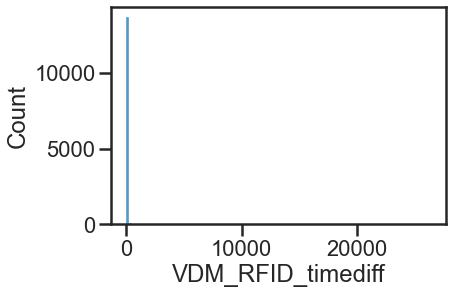

In [31]:
print(data_comb.shape)
sns.histplot(data_comb['VDM_RFID_timediff'], bins=100)
plt.show()

#### Add metadata

In [32]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/meta_data_3m.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_comb = meta_data.merge(data_comb.reset_index(), left_on='IdRFID', right_on='RFID_assign_id_pre', sort=False)

print(data_comb.shape)
data_comb.head()

(14331, 33)


,Round,Cage,Animal,Injury,Unique,IdRFID,weight_pre,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,VDM_RFID_timediff
0,1,1,997,sham,sham_r1_1,041A555A78,33.8,11,1,r1,3m,201120,11/21/20 02:02:01,VDM_05_etoh,0.00250,2020-11-21 02:02:01,1.605924e+09,2020-11-21,21,02:02:01,2,2,dark,2.015,041A555A78,RFID2,2020-11-21 01:07:20.489001600,2020-11-21 01:07:22.504001600,2020-11-21 02:17:53.390976,041A555A78,same,4230.886974,3278.495998
1,1,1,997,sham,sham_r1_1,041A555A78,33.8,56,1,r1,3m,201120,11/21/20 20:31:09,VDM_05_etoh,0.00125,2020-11-21 20:31:09,1.605991e+09,2020-11-21,21,20:31:09,20,31,dark,27.155,041A555A78,RFID2,2020-11-21 20:30:55.442995200,2020-11-21 20:31:22.597995200,2020-11-21 20:31:23.413008,041A55594C,diff,0.815012,0.000000
2,1,1,997,sham,sham_r1_1,041A555A78,33.8,57,1,r1,3m,201120,11/21/20 20:31:12,VDM_05_etoh,0.00125,2020-11-21 20:31:12,1.605991e+09,2020-11-21,21,20:31:12,20,31,dark,27.155,041A555A78,RFID2,2020-11-21 20:30:55.442995200,2020-11-21 20:31:22.597995200,2020-11-21 20:31:23.413008,041A55594C,diff,0.815012,0.000000
3,1,1,997,sham,sham_r1_1,041A555A78,33.8,61,1,r1,3m,201120,11/21/20 20:41:19,VDM_05_etoh,0.00125,2020-11-21 20:41:19,1.605991e+09,2020-11-21,21,20:41:19,20,41,dark,24.626,041A555A78,RFID2,2020-11-21 20:41:13.514035200,2020-11-21 20:41:38.140035200,2020-11-21 20:41:38.454000,041A55594C,diff,0.313964,0.000000
4,1,1,997,sham,sham_r1_1,041A555A78,33.8,62,1,r1,3m,201120,11/21/20 20:41:21,VDM_05_etoh,0.00125,2020-11-21 20:41:21,1.605991e+09,2020-11-21,21,20:41:21,20,41,dark,24.626,041A555A78,RFID2,2020-11-21 20:41:13.514035200,2020-11-21 20:41:38.140035200,2020-11-21 20:41:38.454000,041A55594C,diff,0.313964,0.000000


#### Add day, hour, and min counts

In [33]:
#split by round to get specific dates
data_comb_r1 = data_comb[data_comb['Round'] == 1].sort_values(['VDM_datetime'])
data_comb_r2 = data_comb[data_comb['Round'] == 2].sort_values(['VDM_datetime'])

#column of running day count
dat_map = dict(zip(data_comb_r1['VDM_date'].unique(), np.arange(1,len(data_comb_r1['VDM_date'].unique())+1)))
data_comb_r1['VDM_day_count'] = data_comb_r1['VDM_date'].map(dat_map)
#column of running hour and minute count
data_comb_r1['VDM_hour_count'] = (data_comb_r1['VDM_day_count']*24) + data_comb_r1['VDM_hour'] - 24
data_comb_r1['VDM_min_count'] = (data_comb_r1['VDM_hour_count']*60) + data_comb_r1['VDM_min'] - 60

#column of running day count
dat_map = dict(zip(data_comb_r2['VDM_date'].unique(), np.arange(1,len(data_comb_r2['VDM_date'].unique())+1)))
data_comb_r2['VDM_day_count'] = data_comb_r2['VDM_date'].map(dat_map)
#column of running hour and minute count
data_comb_r2['VDM_hour_count'] = (data_comb_r2['VDM_day_count']*24) + data_comb_r2['VDM_hour'] - 24
data_comb_r2['VDM_min_count'] = (data_comb_r2['VDM_hour_count']*60) + data_comb_r2['VDM_min'] - 60

#combine back together
data_comb_final = pd.concat([data_comb_r1, data_comb_r2], axis=0)
print(data_comb_final.shape)
data_comb_final.head()

(14331, 36)


,Round,Cage,Animal,Injury,Unique,IdRFID,weight_pre,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,VDM_RFID_timediff,VDM_day_count,VDM_hour_count,VDM_min_count
119,1,1,997,sham,sham_r1_1,041A555A78,33.8,1485,1,r1,3m,201120,11/20/20 17:25:56,VDM_H20,0.027,2020-11-20 17:25:56,1.605893e+09,2020-11-20,20,17:25:56,17,25,light,19.508,041A555A78,RFID4,2020-11-20 17:25:47.965008000,2020-11-20 17:26:07.473008000,2020-11-20 17:26:08.760019200,041A555A78,same,1.287011,0.0,1,17,985
120,1,1,997,sham,sham_r1_1,041A555A78,33.8,1486,1,r1,3m,201120,11/20/20 17:25:57,VDM_H20,0.027,2020-11-20 17:25:57,1.605893e+09,2020-11-20,20,17:25:57,17,25,light,19.508,041A555A78,RFID4,2020-11-20 17:25:47.965008000,2020-11-20 17:26:07.473008000,2020-11-20 17:26:08.760019200,041A555A78,same,1.287011,0.0,1,17,985
121,1,1,997,sham,sham_r1_1,041A555A78,33.8,1487,1,r1,3m,201120,11/20/20 17:49:13,VDM_H20,0.027,2020-11-20 17:49:13,1.605895e+09,2020-11-20,20,17:49:13,17,49,light,37.012,041A555A78,RFID4,2020-11-20 17:49:09.695971200,2020-11-20 17:49:46.707971200,2020-11-20 17:49:48.322041600,041A555A78,same,1.614070,0.0,1,17,1009
122,1,1,997,sham,sham_r1_1,041A555A78,33.8,1488,1,r1,3m,201120,11/20/20 17:49:15,VDM_H20,0.027,2020-11-20 17:49:15,1.605895e+09,2020-11-20,20,17:49:15,17,49,light,37.012,041A555A78,RFID4,2020-11-20 17:49:09.695971200,2020-11-20 17:49:46.707971200,2020-11-20 17:49:48.322041600,041A555A78,same,1.614070,0.0,1,17,1009
123,1,1,997,sham,sham_r1_1,041A555A78,33.8,1489,1,r1,3m,201120,11/20/20 17:49:17,VDM_H20,0.027,2020-11-20 17:49:17,1.605895e+09,2020-11-20,20,17:49:17,17,49,light,37.012,041A555A78,RFID4,2020-11-20 17:49:09.695971200,2020-11-20 17:49:46.707971200,2020-11-20 17:49:48.322041600,041A555A78,same,1.614070,0.0,1,17,1009


#### Compute intake per body weight

In [34]:
data_comb_final['drink_bw'] = data_comb_final['value'] / (data_comb_final['weight_pre'] /1000)

In [35]:
data_comb_final.head()

,Round,Cage,Animal,Injury,Unique,IdRFID,weight_pre,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,VDM_RFID_timediff,VDM_day_count,VDM_hour_count,VDM_min_count,drink_bw
119,1,1,997,sham,sham_r1_1,041A555A78,33.8,1485,1,r1,3m,201120,11/20/20 17:25:56,VDM_H20,0.027,2020-11-20 17:25:56,1.605893e+09,2020-11-20,20,17:25:56,17,25,light,19.508,041A555A78,RFID4,2020-11-20 17:25:47.965008000,2020-11-20 17:26:07.473008000,2020-11-20 17:26:08.760019200,041A555A78,same,1.287011,0.0,1,17,985,0.798817
120,1,1,997,sham,sham_r1_1,041A555A78,33.8,1486,1,r1,3m,201120,11/20/20 17:25:57,VDM_H20,0.027,2020-11-20 17:25:57,1.605893e+09,2020-11-20,20,17:25:57,17,25,light,19.508,041A555A78,RFID4,2020-11-20 17:25:47.965008000,2020-11-20 17:26:07.473008000,2020-11-20 17:26:08.760019200,041A555A78,same,1.287011,0.0,1,17,985,0.798817
121,1,1,997,sham,sham_r1_1,041A555A78,33.8,1487,1,r1,3m,201120,11/20/20 17:49:13,VDM_H20,0.027,2020-11-20 17:49:13,1.605895e+09,2020-11-20,20,17:49:13,17,49,light,37.012,041A555A78,RFID4,2020-11-20 17:49:09.695971200,2020-11-20 17:49:46.707971200,2020-11-20 17:49:48.322041600,041A555A78,same,1.614070,0.0,1,17,1009,0.798817
122,1,1,997,sham,sham_r1_1,041A555A78,33.8,1488,1,r1,3m,201120,11/20/20 17:49:15,VDM_H20,0.027,2020-11-20 17:49:15,1.605895e+09,2020-11-20,20,17:49:15,17,49,light,37.012,041A555A78,RFID4,2020-11-20 17:49:09.695971200,2020-11-20 17:49:46.707971200,2020-11-20 17:49:48.322041600,041A555A78,same,1.614070,0.0,1,17,1009,0.798817
123,1,1,997,sham,sham_r1_1,041A555A78,33.8,1489,1,r1,3m,201120,11/20/20 17:49:17,VDM_H20,0.027,2020-11-20 17:49:17,1.605895e+09,2020-11-20,20,17:49:17,17,49,light,37.012,041A555A78,RFID4,2020-11-20 17:49:09.695971200,2020-11-20 17:49:46.707971200,2020-11-20 17:49:48.322041600,041A555A78,same,1.614070,0.0,1,17,1009,0.798817


### Export data

In [36]:
data_VDM_tidy_intake.to_csv('data_VDM_tidy_intake_3m.csv')
data_RFID_final.to_csv('data_RFID_final_3m.csv')
data_comb_final.to_csv('data_comb_final_3m.csv')